In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys() # DESCR describe dataset, data one row per instance and one column for feature

In [ ]:
X, y = mnist['data'], mnist['target']
print(f'X shape: {X.shape}') # feature length of 748
print('y shape: ', y.shape)

X shape: (70000, 784)
y shape:  (70000,)


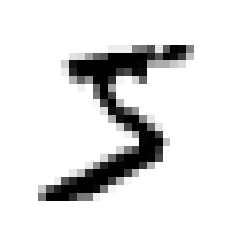

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [ ]:
y[0]

'5'

In [ ]:
# convert string label to int
y = y.astype(np.uint8)

In [ ]:
# mnist already define training and test set (first 60000 are traninig)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary classifier 5 detector

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
print('Predict 5 example ', y_test_5[:10]) # its like one hot

Predict 5 example  [False False False False False False False False  True False]


In [ ]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
sgd.predict([some_digit]) # predict image that contains 5

array([ True])

### Measure performance using cross-validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_folds = X_train[test_index]
  y_test_folds = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_folds)
  right_prediction = sum(y_pred == y_test_folds)
  print(right_prediction / len(y_pred))

0.9669
0.91625
0.96785


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(sgd, X_train, y_train_5, cv=3, scoring='accuracy') # 1 fold as test set, 2 fold as traning. Model is trained 3 times
print('Scores: ', scores)
print('Mean: ', scores.mean())
print('Stddev: ', scores.std())

Scores:  [0.95035 0.96035 0.9604 ]
Mean:  0.9570333333333334
Stddev:  0.004725874404688398


In [ ]:
# not 5 classifier
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None): pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5 = Never5Classifier()
scores = cross_val_score(never_5, X_train, y_train_5, cv=3, scoring='accuracy') # 1 fold as test set, 2 fold as traning. Model is trained 3 times
print('Scores: ', scores)
print('Mean: ', scores.mean())
print('Stddev: ', scores.std())
# 90 % here, this means that only 10% of images contains 5.
# this means taht 90% times the classifier do the right thing. Accuracy is not a right indicator

Scores:  [0.91125 0.90855 0.90915]
Mean:  0.90965
Stddev:  0.0011575836902790325


In [ ]:
# confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
# metriche coincisce: precision e recall
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred) # TP / (TP + FP) # quando dice che è 5 ci becca x percento volte
recall = recall_score(y_train_5, y_train_pred) # individua x percento volte i 5
print(f'Precision: {precision}, Recall: {recall}')

Precision: 0.8370879772350012, Recall: 0.6511713705958311


In [ ]:
# f1 - score is high when precision and recall are high
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

A volte si tara se si vuole avere più precision o più recall a seconda del contesto

In [ ]:
# si usano soglie diverse con sklearn non posso direttamente cambiare soglia
# ma posso prendere i valori di decisioni e fare una scelta su quelli

y_scores = sgd.decision_function([some_digit])
print('Decision values: ', y_scores)
threshold = 0
y_some_digit_pred = y_scores > threshold
print('Prediction ', y_some_digit_pred)

Decision values:  [2164.22030239]
Prediction  [ True]


In [ ]:
# higher threshold increase precsion lowering recall
threshold = 8000
y_some_digit_pred = y_scores > threshold
print('Prediction ', y_some_digit_pred)

Prediction  [False]


In [ ]:
# how to find right threshold? use precision-recall curve
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3, method='decision_function') # call this instead of predict method

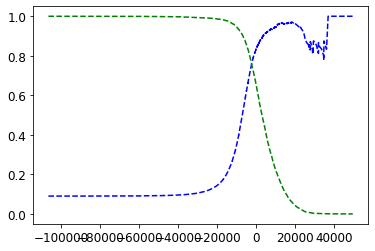

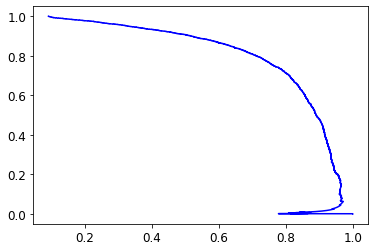

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g--", label="Recall")


def precision_vs_recall(precisions, recalls):
  plt.plot(precisions, recalls, "b", label="Prec vs Recall")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
precision_vs_recall(precisions, recalls)
plt.show()

In [ ]:
# an example select the threshold that give 90% of precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

3370.0194991439557


In [ ]:
# predict with above threhsold
y_train_pred_90 = (y_scores >= threshold_90_precision)
print('Precision: ', precision_score(y_train_5, y_train_pred_90)) # we expect 90
print('Recall ', recall_score(y_train_5, y_train_pred_90)) # we expect lower value

Precision:  0.9000345901072293
Recall  0.4799852425751706


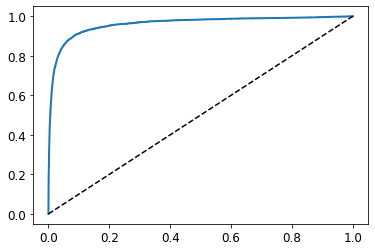

In [ ]:
# ROC CURVE = plot tp rate vs fp rate
from sklearn.metrics import roc_curve

def plot_roc(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], "k--") # random classifier

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plot_roc(fpr, tpr)
plt.show()

In [ ]:
# AUC l'area sotto la curva ROC.
# if is near to 1 is good, near to 0.5 is random classifier

from sklearn.metrics import roc_auc_score
print('Area ', roc_auc_score(y_train_5, y_scores))

Area  0.9604938554008616


### Train random forest and compare with SGD (above)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest, X_train, y_train_5, cv=3, method='predict_proba')

In [ ]:
y_scores_forest = y_probs_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

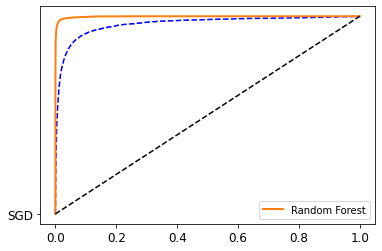

In [ ]:
plt.plot(fpr, tpr, "b--", "SGD")
plot_roc(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

In [ ]:
# auc (area under curve)
area = roc_auc_score(y_train_5, y_scores_forest) # higher than sgd
print(f'AUC: {area}') # better than sgd classifier

AUC: 0.9983436731328145


## Multiclass classifier
* si può usare classificatori binary (tipo SVM) addestrando più classificatori con politiche OvA( one vs all), OvO(one vs one)
* usando classificatori già multiclass (tipo SGDClassifier, Random Forest)
* sklearn riconosce il tipo di classificatore e usa OvA o OvO di nascosto

In [ ]:
 # test con SVM, qua sotto usa OvO, con MINIST genera 45 classificatori binari SVM
 from sklearn.svm import SVC
 svm = SVC()
 svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svm.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
some_digit_score = svm.decision_function([some_digit])
print(some_digit_score)

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]


In [ ]:
np.argmax(some_digit_score)

5

In [ ]:
# force using one versus all
from sklearn.multiclass import OneVsRestClassifier
ovr = OneVsRestClassifier(SVC())
ovr.fit(X_train[:100], y_train[:100]) # too time with bigger training set
ovr.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
# use sgd no OvA or OvO
sgd.fit(X_train, y_train)
sgd.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
val_score = cross_val_score(sgd, X_train, y_train, cv=3, scoring="accuracy")
print(f'Cross validation scores: {val_score}')

Cross validation scores: [0.87365 0.85835 0.8689 ]


In [ ]:
# using standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
scaled_val_score = cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring="accuracy")
print(f'Cross validation scores with scaling: {scaled_val_score}')

In [ ]:
# Error analysis
y_train_pred = cross_val_predict(sgd, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# show the errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
# fill diagonal for keep out the correct and isolate only errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()